# 1. Set up the notebook

Import modules.

In [8]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from IPython.display import display, IFrame, HTML

Define a function to load flight data from hardware experiments and resample it at 100 Hz using linear interpolation, optionally discarding data from the start or end of your experiment.

In [9]:
def load_hardware_data(filename, t_min_offset=0, t_max_offset=0):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
        
    # return the resampled data
    return resampled_data

Define a function to embed videos that have been uploaded to [Illinois Mediaspace](https://mediaspace.illinois.edu/).

In [10]:
def mediaspace(url, width=640, height=397):
    video_id = url.rsplit('/', 1)[-1]
    src = f'https://mediaspace.illinois.edu/embed/secure/iframe/entryId/{video_id}?st=0'
    display(IFrame(src, width=width, height=height))
    display(HTML(f'<a href="{url}" target="_blank">Go to video on Illinois Mediaspace</a>'))

# 2. Define constants

Define the acceleration of gravity in $\text{kg}\cdot\text{m} \;/\; \text{s}^2$:

In [17]:
g = 9.81

Define the mass of the drone in $\text{kg}$:

In [18]:
m = 0.0351 # kg

Define the principle moment of inertia about the $z$ axis in $\text{kg}\cdot\text{m}^2$:

In [19]:
J_z = 3.32e-05 # kg.m2

Using a ruler, measure the distance $l$ in **meters** along both the $x$ and $y$ axis from the center of mass to the center of each rotor.

In [20]:
l = 6.7/200 # kg.m2

# 3. Find the force parameter

### 3.1 Show video of flight

In the following cell, show a video of your flight to collect data (change the url as appropriate).

### 3.2 Get and plot flight data

Load and resample data.

In [39]:
data = load_hardware_data(
    'force_flight_project.json',
    t_min_offset=1.,
    t_max_offset=1.,
)

Parse data to get:
* time
* the accelerometer measurements (**note!** these are in units of "g's")
* the motor power commands

In [40]:
t = data['time']
a_x = g * data['acc.x']
a_y = g * data['acc.y']
a_z = g * data['acc.z']
m_1 = data['motor.m1']
m_2 = data['motor.m2']
m_3 = data['motor.m3']
m_4 = data['motor.m4']

Plot accelerometer measurements and motor power commands. Since the rotors generate force only in the body-fixed $z$ direction, the $x$ and $y$ accelerometer measurements should be much smaller than the $z$ accelerometer measurements. It is important to check this. (Also remember to use `t_min_offset` and `t_max_offset` so that you only look at data from when you are *actually flying.*)

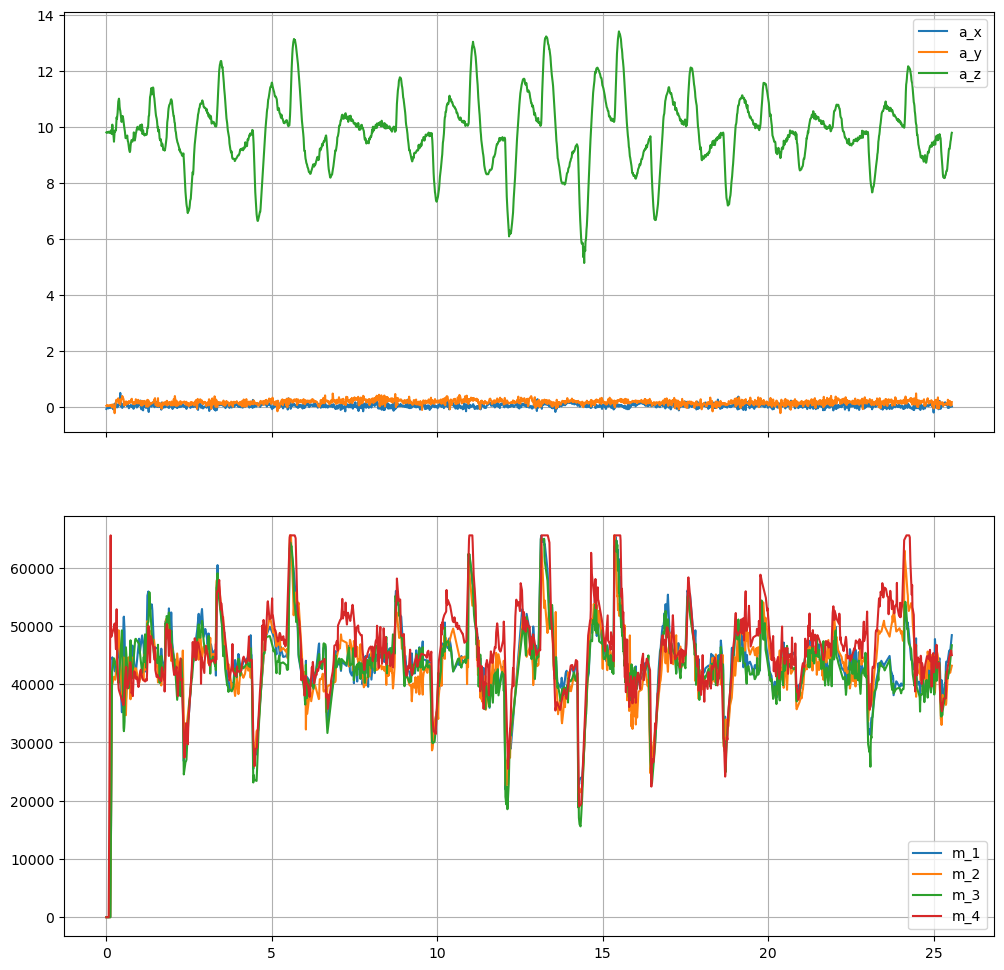

In [41]:
fig, (ax_a, ax_m) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
ax_a.plot(t, a_x, label='a_x')
ax_a.plot(t, a_y, label='a_y')
ax_a.plot(t, a_z, label='a_z')
ax_a.legend()
ax_a.grid()
ax_m.plot(t, m_1, label='m_1')
ax_m.plot(t, m_2, label='m_2')
ax_m.plot(t, m_3, label='m_3')
ax_m.plot(t, m_4, label='m_4')
ax_m.legend()
ax_m.grid()

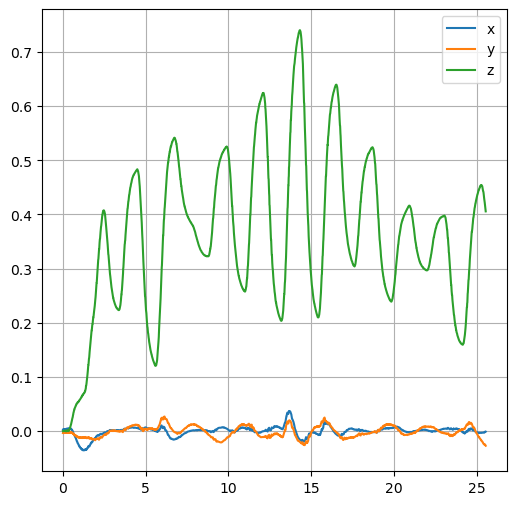

In [42]:
t = data['time']
x = data['stateEstimate.x']
y = data['stateEstimate.y']
z = data['stateEstimate.z']

fig, ax_a = plt.subplots(1, 1, figsize=(6, 6), sharex=True)
ax_a.plot(t, x, label='x')
ax_a.plot(t, y, label='y')
ax_a.plot(t, z, label='z')
ax_a.legend()
ax_a.grid()

### 3.3 Apply linear regression to estimate $k_F$

First, compute `x`.

In [43]:
x = m_1 + m_2 + m_3 + m_4 

Second, compute `y`.

In [44]:
y = m * a_z

Third, compute `c_est`.

In [45]:
c_est = np.sum(y * x) / np.sum(x**2) 

Finally, compute `k_F` in terms of `c_est`.

In [46]:
k_F = c_est 

Show the estimate.

In [47]:
print(f'k_F = {k_F:.2e}')

k_F = 1.95e-06


### 3.4 Validate your estimate

Compare the linear fit to the raw data.

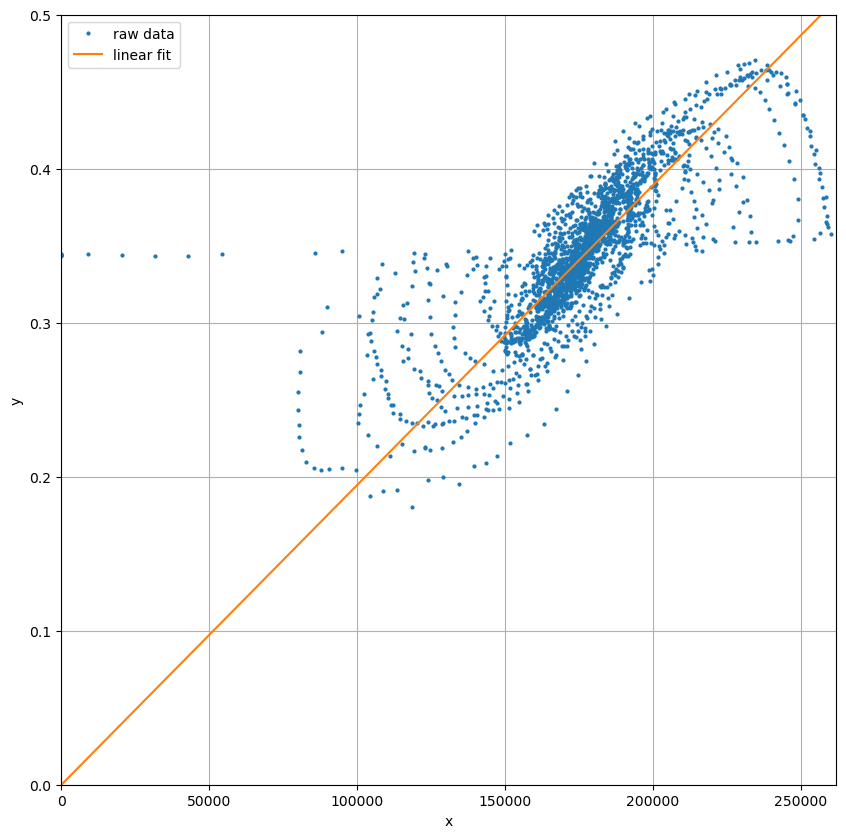

In [51]:
plt.figure(figsize=(10, 10))
plt.plot(x, y, '.', markersize=4, label='raw data')
plt.plot([0, 262140], [c_est * 0, c_est * 262140], label='linear fit')
plt.xlim(0, 262140)
plt.xlabel('x')
plt.ylim(0, 0.5)
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

Compare the z-axis accelerometer measurement to what you would have predicted with your estimate of $k_F$.

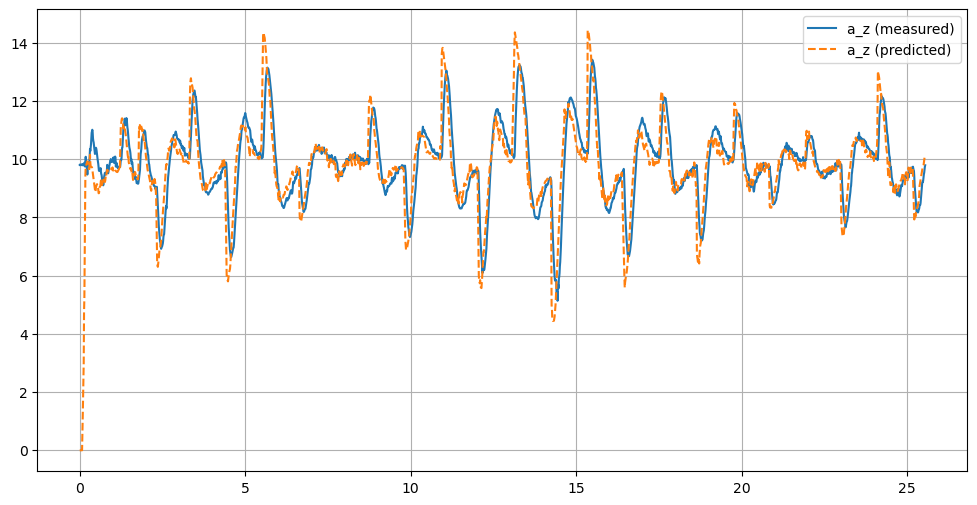

In [50]:
a_z_predicted = x * c_est/m 

plt.figure(figsize=(12, 6))
plt.plot(t, a_z, label='a_z (measured)')
plt.plot(t, a_z_predicted, '--', label='a_z (predicted)')
plt.grid()
plt.legend()
plt.show()

# 4. Find the moment parameter

### 4.1 Show video of flight

In the following cell, show a video of your flight to collect data (change the url as appropriate).

### 4.2 Get and plot flight data

Load and resample data.

In [52]:
data = load_hardware_data(
    'yaw.json',
    t_min_offset=1.,
    t_max_offset=1.,
)

FileNotFoundError: [Errno 2] No such file or directory: 'yaw.json'

Parse data to get:
* time
* the gyroscope measurements (**note!** these are in units of degrees / second)
* the motor power commands

In [ ]:
t = data['time']
w_x = np.deg2rad(data['gyro.x'])
w_y = np.deg2rad(data['gyro.y'])
w_z = np.deg2rad(data['gyro.z'])
m_1 = data['motor.m1']
m_2 = data['motor.m2']
m_3 = data['motor.m3']
m_4 = data['motor.m4']

Find the time step. It should be `0.01` because data were sampled at 100 Hz.

In [29]:
dt = t[1] - t[0]
print(f'dt = {dt}')

dt = 0.01


Plot gyroscope measurements and motor power commands. Since the drone was near hover during flight (only yawing back and forth), the $x$ and $y$ gyroscope measurements should be much smaller than the $z$ gyroscope measurements. It is important to check this. (Also remember to use `t_min_offset` and `t_max_offset` so that you only look at data from when you are *actually flying.*)

NameError: name 'w_x' is not defined

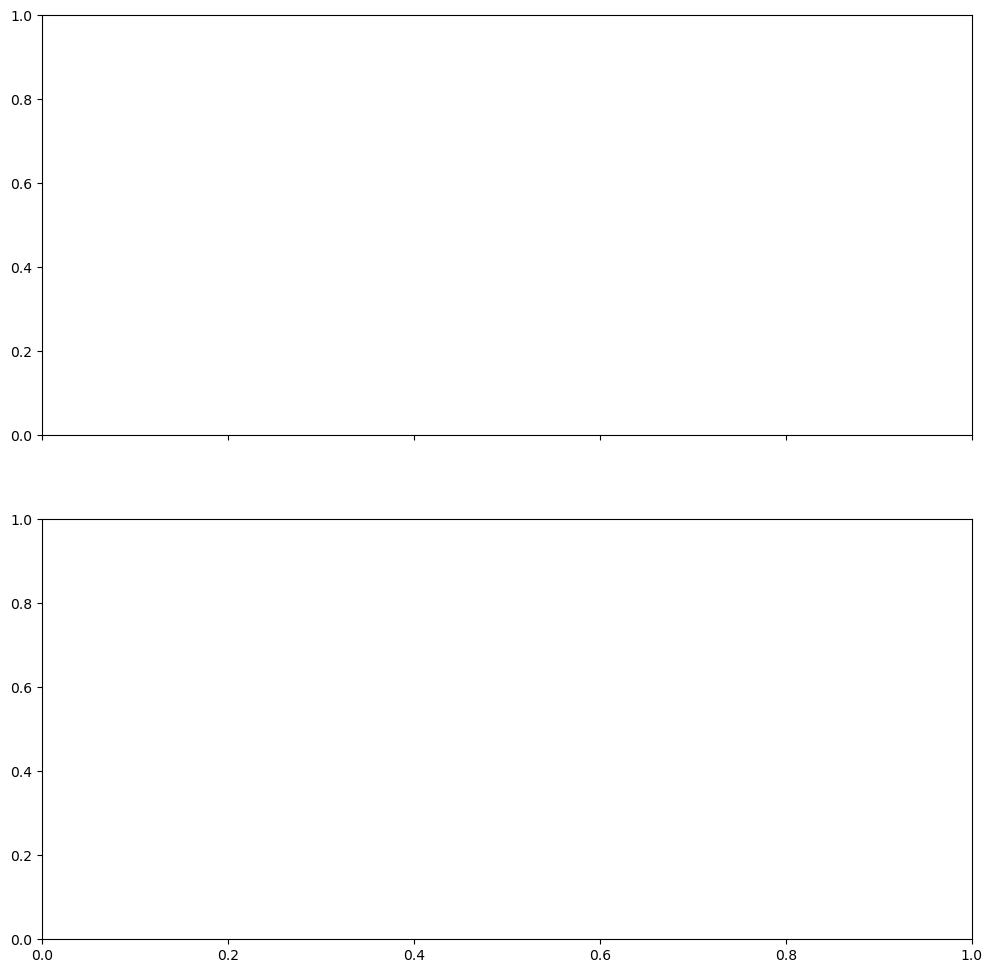

In [30]:
fig, (ax_w, ax_m) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
ax_w.plot(t, w_x, label='w_x')
ax_w.plot(t, w_y, label='w_y')
ax_w.plot(t, w_z, label='w_z')
ax_w.legend()
ax_w.grid()
ax_m.plot(t, m_1, label='m_1')
ax_m.plot(t, m_2, label='m_2')
ax_m.plot(t, m_3, label='m_3')
ax_m.plot(t, m_4, label='m_4')
ax_m.legend()
ax_m.grid()

### 6.3 Use finite difference to estimate $\dot{w}_z$

Estimate $\dot{w}_z$ by finite difference.

In [ ]:
w_z_dot = (w_z[1:] - w_z[:-1]) / dt # <-- FIXME (REPLACE WITH CODE TO COMPUTE W_Z BY FINITE DIFF

Plot both $w_z$ and $\dot{w}_z$.

**This code, unmodified, will result in an error!** This is because `w_z_dot` has one fewer element than `w_z` and `t`. Do you remember what you need to change? Fix it.

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(t, w_z, label='$w_z$')
plt.plot(t[:-1], w_z_dot, '--', label='$\dot{w}_z$')
plt.grid()
plt.legend(fontsize=16)

### 6.4 Apply linear regression to estimate $k_M$

First, compute `x`.

In [31]:
x = - m_1 + m_2 - m_3 + m_4 # <-- FIXME (REPLACE WITH CODE TO DEFINE THE "X" IN LINEAR REGRESSION)

Second, compute `y`.

In [32]:
y = J_z * w_z_dot # <-- FIXME (REPLACE WITH CODE TO DEFINE THE "Y" IN LINEAR REGRESSION)

NameError: name 'w_z_dot' is not defined

Third, compute `c_est`.

**If you do this without thinking, you will get an error!** In particular, you will likely see something like this:

```
ValueError: operands could not be broadcast together with shapes (1313,) (1314,)
```

The reason for this error is that you are trying to add, subtract, multiply, or divide (element-wise) two 1D numpy arrays that have different lengths. Remember, in particular, that `w_z_dot` has one fewer element than everything else. What will you need to change in order to make your code work without error?

In [33]:
x = x[1:]
c_est = c_est = np.sum(y * x) / np.sum(x**2) # <-- FIXME (REPLACE WITH CODE TO COMPUTE THE ESTIMATE OF "C" IN LINEAR REGRESSION)

ValueError: operands could not be broadcast together with shapes (2556,) (2555,) 

Finally, compute `k_M` in terms of `c_est`.

In [34]:
k_M = c_est # <-- FIXME (REPLACE WITH CODE TO COMPUTE K_M GIVEN C_EST - LIKELY VERY SIMPLE!)

Show the estimate.

In [35]:
print(f'k_M = {k_M:.2e}')

k_M = 1.95e-06


### 6.4 Validate your estimate

Compare the linear fit to the raw data.

ValueError: x and y must have same first dimension, but have shapes (2555,) and (2556,)

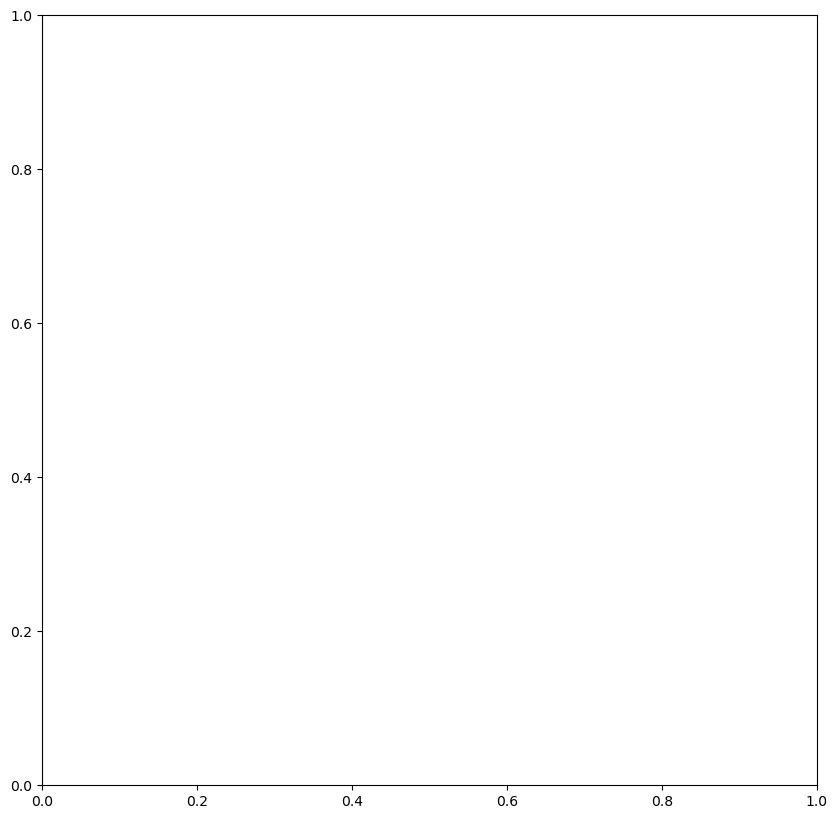

In [36]:
plt.figure(figsize=(10, 10))
plt.plot(x, y, '.', markersize=12, label='raw data')
plt.plot([-131070, 131070], [c_est * -131070, c_est * 131070], label='linear fit')
plt.xlim(-131070, 131070)
plt.xlabel('x')
plt.ylim(-.002, 0.002)
plt.ylabel('y')
plt.grid()
plt.legend()

Compare the finite-difference estimate of $\dot{w}_z$ to what you would have predicted using $k_M$. **Again, you will likely have to modify this code for it to execute without error - be careful about the lengths of your arrays!**

In [ ]:
w_z_dot_predicted = k_M/J_z * x # <-- FIXME (REPLACE WITH CODE TO COMPUTE
                       #     W_Z_DOT AS PREDICTED FROM YOUR ESTIMATE
                       #     OF K_F, THE MOMENT OF INERTIA J_Z, AND
                       #     THE MOTOR POWER COMMANDS)

plt.figure(figsize=(12, 6))
plt.plot(t[1:], w_z_dot, label='$\dot{w}_z$ (measured)')
plt.plot(t[1:], w_z_dot_predicted, '--', label='$\dot{w}_z$ (predicted)')
plt.grid()
plt.legend()

# 7. Summarize and discuss the results

### Summary of results

In [48]:
print(f'l = {l:.2} m')
print(f'k_F = {k_F:.2e}')
print(f'k_M = {k_M:.2e}')

l = 0.034 m
k_F = 1.95e-06
k_M = 7.47e-09
